In [58]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append('../mchem_functions')
import PCA_functions as pcf
import multivariate_functions as mvf

In [59]:
chosen_PCs = [1,2]
no_of_components = 5

scaling_method = 'SNV'

nmr_data_dir = '../../Data/NMR'
nmr_spectra_dir = 'txt_spectra'
nmr_data_arc = 'nmr_archive'

In [60]:
try: os.chdir(nmr_data_dir)
except FileNotFoundError: pass

In [61]:
sites_long_names = {
    'HM': 'Hare Moss',
    'AM': 'Auchencorth Moss'
}

def get_attr(s:str):
    s = s.replace('MP-','').replace('PW-','')
    sample_name = s
    s = s.split('-')
    site = s[0]
    sitelong = sites_long_names[site]
    season = s[-2]
    replicate = s[-1]

    return sample_name,site,sitelong,season,replicate

In [62]:
path = f"{nmr_data_arc}\\*\\11\\pdata\\*\\integrals.txt"
integral_files = glob.glob(path)
integrals_list = []
attribute_list = []

for file in integral_files:

    # make sure all -'s are separated with at least one space
    with open(file, 'r') as f:
        filedata = f.read()
    filedata = filedata.replace('-', ' -')
    with open(file, 'w') as f:
        f.write(filedata)
    f.close()

    int_df = pd.read_csv(file,skiprows=4,sep=r"\s+")
    integrals_list.append(int_df['Integral'].to_numpy())
    attribute_list.append([*get_attr(file.split('\\')[1])])

    if len(integrals_list[-1]) == 0:
        print(attribute_list[-1])

ppm = np.mean(int_df[['Integrated','Region']].to_numpy(),axis=1)

attribute_array = np.array(attribute_list)
integrals_arr = np.array(integrals_list)
no_of_spectra = len(integrals_arr)

In [63]:
row_sum = np.sum(integrals_arr,axis=1)
integrals_arr = integrals_arr / np.reshape(row_sum,(len(row_sum),1))

(9.995000000000001, -0.095)

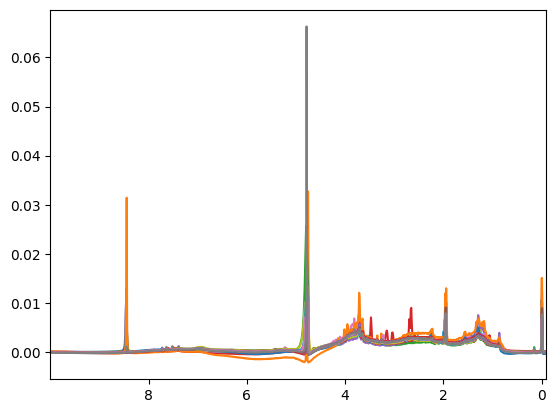

In [64]:
fig_unproc,ax_unproc = plt.subplots()
for i in range(no_of_spectra):
    ax_unproc.plot(ppm,integrals_arr[i,:])

ax_unproc.set_xlim(np.max(ppm),np.min(ppm))

In [65]:
# set regions to exclude and exclude them
regions_to_exclude = [[np.min(ppm),0.5],
                      [1.92,2],
                      [4.5,5.8], #[4.5,5.07]             
                      [8.2,np.max(ppm)]] # 8.2,9

idx_to_exclude = []
for r in regions_to_exclude:
    idx_to_exclude += [*np.where((ppm>=np.min(r))&(ppm<=np.max(r)))[0]]
idx_to_exclude = np.array(idx_to_exclude)
idx_to_include = np.array([x for x in np.arange(len(ppm)) if x not in idx_to_exclude])
ppm = ppm[idx_to_include]
integrals_arr = integrals_arr[:,idx_to_include]

(1.92, 0.5)
(4.5, 2)
(8.2, 5.8)


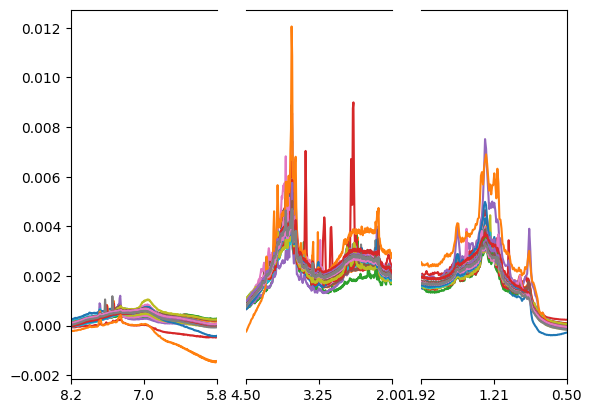

In [66]:
fig_unproc,ax_unproc = plt.subplots(1,len(regions_to_exclude)-1)

for ax in ax_unproc:
    for i in range(no_of_spectra):
        ax.plot(ppm,integrals_arr[i,:])
    
    if ax == ax_unproc[0]:
        ax.spines['right'].set_visible(False)

    elif ax == ax_unproc[-1]:
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_tick_params(labelleft=False)
        ax.set_yticks([])
    
    else:
        ax.tick_params(labelright='off',labelleft='off')
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.tick_params(labelright='off')
        ax.set_yticks([])
        ax.yaxis.set_tick_params(labelleft=False,labelright=False)

for i in range(len(ax_unproc)):

    xlim = (regions_to_exclude[i+1][0],regions_to_exclude[i][1])
    print(xlim)

    xticks = np.linspace(np.min(xlim),np.max(xlim),3)#list(range(0,10,2))+list(xlim)
    xticks.sort()

    ax_unproc[np.arange(len(ax_unproc))[::-1][i]].set_xticks(xticks)
    ax_unproc[np.arange(len(ax_unproc))[::-1][i]].set_xlim(xlim)


(8.195, 0.505)

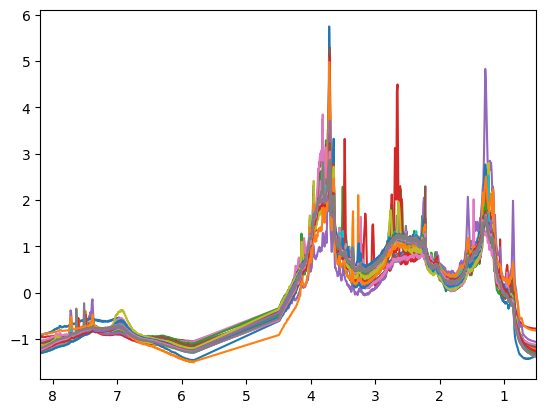

In [67]:
fig_snv,ax_snv = plt.subplots()

snv = mvf.SNV(integrals_arr)

for i in range(no_of_spectra):
    ax_snv.plot(ppm,snv[i,:],label=attribute_array[:,0][i])
# ax_snv.legend()
ax_snv.set_xlim(np.max(ppm),np.min(ppm))
# ax_snv.set_xlim(8.6,8.4)

In [68]:
no_of_pcs = 5
scores_values, variance_ratio, PCs, loadings = pcf.get_pca_data(snv,method=None,no_of_components=no_of_pcs)

In [69]:
m_shape = {
    'Hare Moss': 'o',
    'Auchencorth Moss': 's',
}

seasonal_colours = {
    'Aut': '#BF5700', # burnt orange
    'Win1': '#4B61D1', # Savoy blue
    'Win2': '#4E2A84', # northwestern purple
    'Spr': '#E0B0FF', # mauve
    'Sum': '#50C878', # emerald green
}

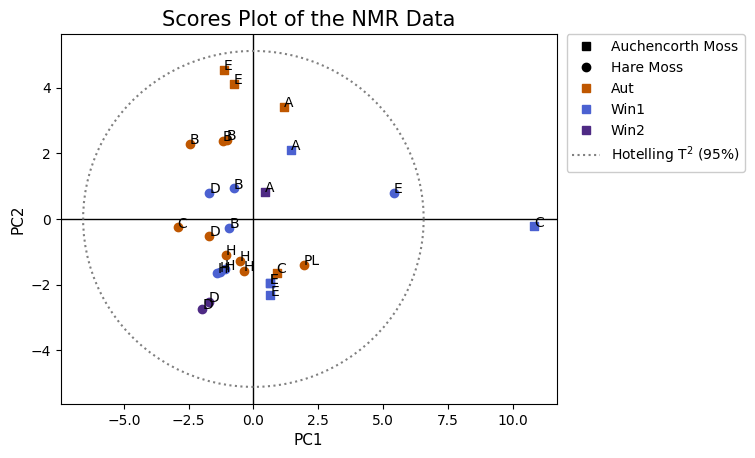

In [70]:
fig_scores, ax_scores = plt.subplots()

for site in np.unique(attribute_array[:,2]):
    for season in np.unique(attribute_array[:,3]):

        idx = np.where((attribute_array[:,2] == site)&(attribute_array[:,3] == season))

        pcf.scores_plot(scores_values[idx],chosen_PCs,lines=False,ax=ax_scores,marker=m_shape[site],c=seasonal_colours[season])

       
pcf.Hotelling(scores_values,chosen_PCs,ax_scores)

title = f'Scores Plot of the NMR Data'
ax_scores.set_title(title,fontsize=15)
ax_scores.axhline(y=0, color = '#000', linewidth = 1, zorder=-1)
ax_scores.axvline(x=0, color = '#000', linewidth = 1, zorder=-1)

# Adapted from https://stackoverflow.com/questions/45140295/how-to-create-a-legend-of-both-color-and-marker
f = lambda m,c,ls: ax_scores.plot([],[],marker=m, color=c, ls=ls)[0]
handles = []
labels  = []
for site in np.unique(attribute_array[:,2]):
    handles.append(f(m_shape[site], "k", ls="none"))
    labels.append(site)
for season in np.unique(attribute_array[:,3]):
    handles.append(f('s', seasonal_colours[season],ls="none"))
    labels.append(season)

handles += [f('none', "grey",ls=":")]
labels += ['Hotelling T$^{2}$ (95%)']
ax_scores.legend(handles, labels, framealpha=1,bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
fig_scores.savefig(f'plots/{title.lower().replace(' ','_')}.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')

for i in range(no_of_spectra):
    ax_scores.text(scores_values[i,chosen_PCs[0]-1],scores_values[i,chosen_PCs[1]-1],attribute_array[i,0].split('-')[1])

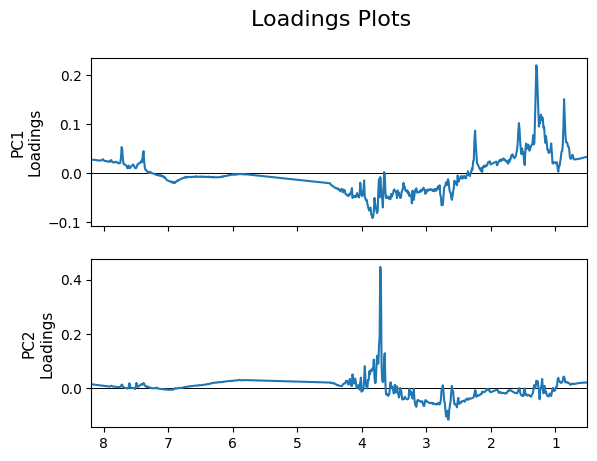

In [71]:
fig_loadings = plt.figure()
ax_loadings = fig_loadings.subplots(len(chosen_PCs),sharex=True)

pcf.loadings_plot(ppm,loadings.T,chosen_PCs,ax=ax_loadings,fig=fig_loadings)
ax_loadings[0].set_xlim(np.max(ppm),np.min(ppm))
# ax_loadings[0].set_xlim(9,8)

fig_loadings.savefig(f'plots/loadings_plots.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')

In [72]:
ppm[np.where(loadings[0,:]==np.min(loadings[0,:]))],ppm[np.where(loadings[0,:]==np.max(loadings[0,:]))]

(array([3.835]), array([1.295]))

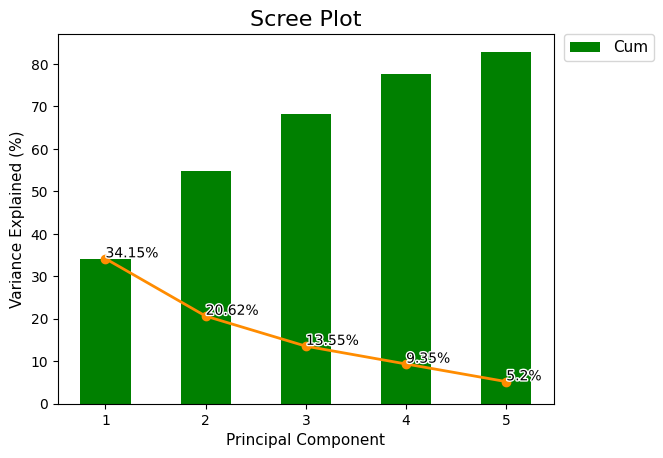

In [73]:
pcf.scree_plot(PCs,variance_ratio,save_path=f'plots/scree_plot.svg')

In [74]:
scores_values_HM, variance_ratio_HM, PCs_HM, loadings_HM = pcf.get_pca_data(snv[np.where(attribute_array[:,1]=='HM')[0]],method=None)
scores_values_AM, variance_ratio_AM, PCs_AM, loadings_AM = pcf.get_pca_data(snv[np.where(attribute_array[:,1]=='AM')[0]],method=None)

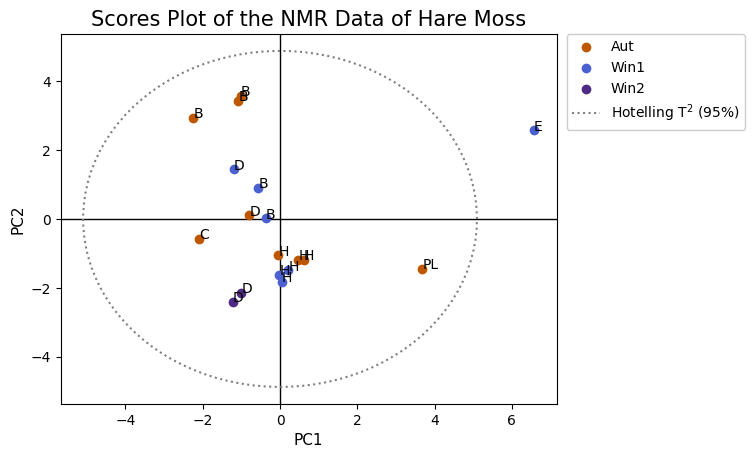

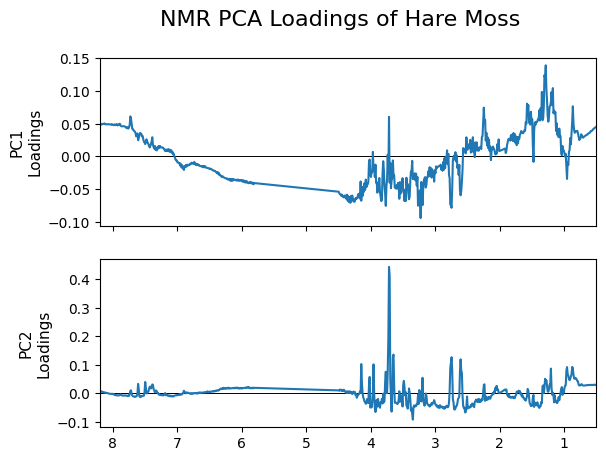

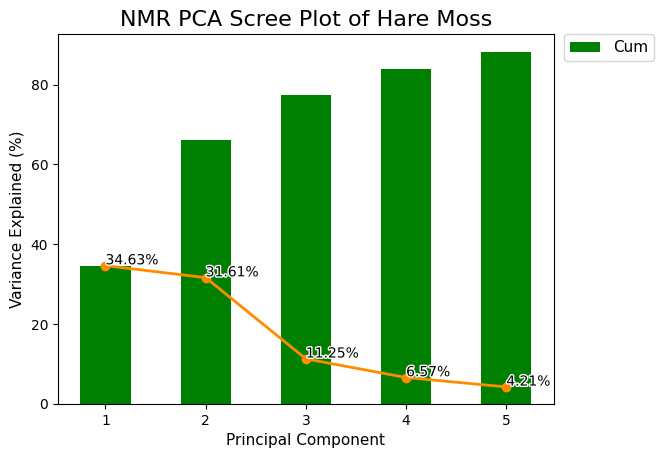

In [75]:
fig_scores_HM, ax_scores_HM = plt.subplots()

for season in np.unique(attribute_array[:,3]):

    idx = np.where(attribute_array[np.where(attribute_array[:,1]=='HM')][:,3] == season)

    pcf.scores_plot(scores_values_HM[idx],chosen_PCs,lines=False,ax=ax_scores_HM,marker=m_shape['Hare Moss'],c=seasonal_colours[season],label=season)

pcf.Hotelling(scores_values_HM,chosen_PCs,ax_scores_HM)

title = f'Scores Plot of the NMR Data of Hare Moss'
ax_scores_HM.set_title(title,fontsize=15)
ax_scores_HM.axhline(y=0, color = '#000', linewidth = 1, zorder=-1)
ax_scores_HM.axvline(x=0, color = '#000', linewidth = 1, zorder=-1)

ax_scores_HM.legend(framealpha=1,bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
fig_scores_HM.savefig(f'plots/{title.lower().replace(' ','_')}.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')

for i in range(len(scores_values_HM)):
    ax_scores_HM.text(scores_values_HM[i,chosen_PCs[0]-1],scores_values_HM[i,chosen_PCs[1]-1],attribute_array[np.where(attribute_array[:,1]=='HM')][i,0].split('-')[1])

#---
fig_loadings_HM = plt.figure()
ax_loadings_HM = fig_loadings_HM.subplots(len(chosen_PCs),sharex=True)

pcf.loadings_plot(ppm,loadings_HM.T,chosen_PCs,ax=ax_loadings_HM,fig=fig_loadings_HM,title='NMR PCA Loadings of Hare Moss')
ax_loadings_HM[0].set_xlim(np.max(ppm),np.min(ppm))
# ax_loadings_HM[0].set_xlim(9,8)

fig_loadings_HM.savefig(f'plots/loadings_HM_plots.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')

#---
pcf.scree_plot(range(1,np.min([len(PCs_HM),no_of_pcs])+1),variance_ratio_HM,save_path=f'plots/scree_plot.svg',title='NMR PCA Scree Plot of Hare Moss')

In [76]:
ppm[np.where(loadings_HM[0,:]==np.min(loadings_HM[0,:]))],ppm[np.where(loadings_HM[0,:]>0.1)]

(array([3.225]), array([1.305, 1.295, 1.285, 1.275, 1.175]))

In [77]:
loadings_HM[0,:][np.where(ppm==2.225)]

array([0.05579455])

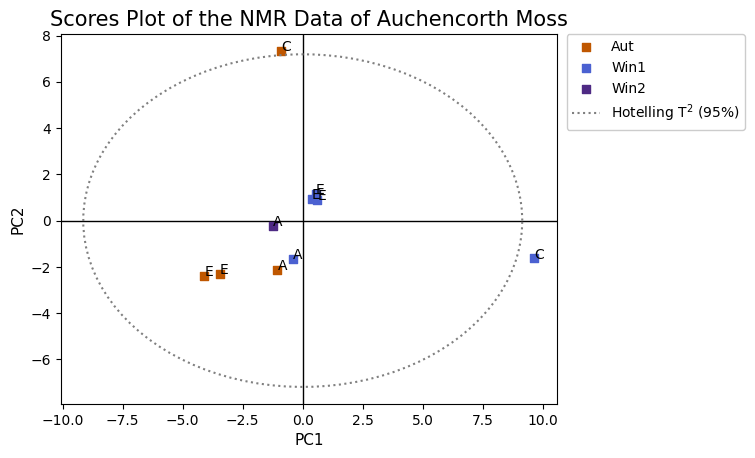

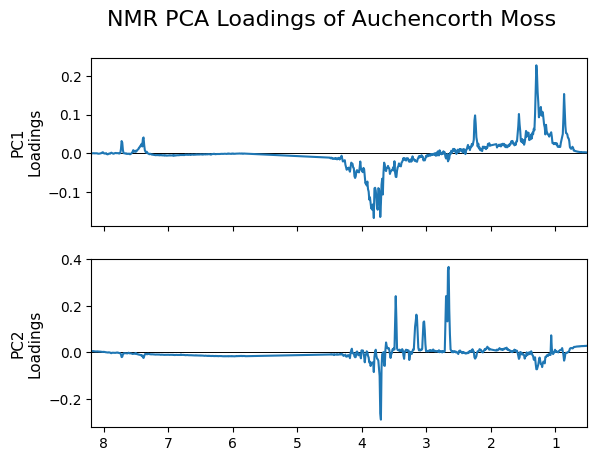

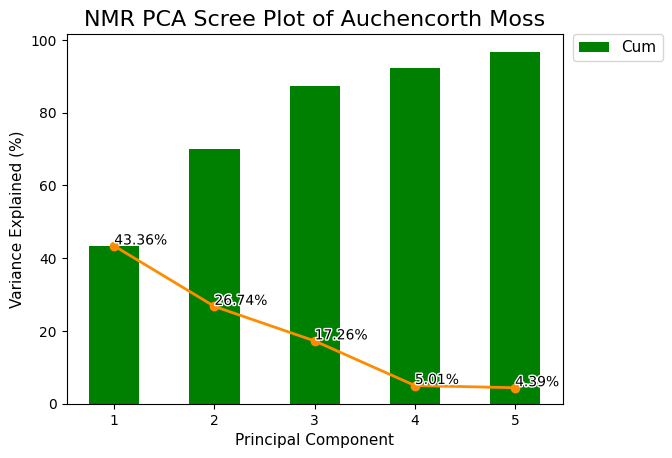

In [78]:
fig_scores_AM, ax_scores_AM = plt.subplots()

for season in np.unique(attribute_array[:,3]):

    idx = np.where(attribute_array[np.where(attribute_array[:,1]=='AM')][:,3] == season)

    pcf.scores_plot(scores_values_AM[idx],chosen_PCs,lines=False,ax=ax_scores_AM,marker=m_shape['Auchencorth Moss'],c=seasonal_colours[season],label=season)

pcf.Hotelling(scores_values_AM,chosen_PCs,ax_scores_AM)

title = f'Scores Plot of the NMR Data of Auchencorth Moss'
ax_scores_AM.set_title(title,fontsize=15)
ax_scores_AM.axhline(y=0, color = '#000', linewidth = 1, zorder=-1)
ax_scores_AM.axvline(x=0, color = '#000', linewidth = 1, zorder=-1)

ax_scores_AM.legend(framealpha=1,bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
fig_scores_AM.savefig(f'plots/{title.lower().replace(' ','_')}.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')

for i in range(len(scores_values_AM)):
    ax_scores_AM.text(scores_values_AM[i,chosen_PCs[0]-1],scores_values_AM[i,chosen_PCs[1]-1],attribute_array[np.where(attribute_array[:,1]=='AM')][i,0].split('-')[1])

#---
fig_loadings_AM = plt.figure()
ax_loadings_AM = fig_loadings_AM.subplots(len(chosen_PCs),sharex=True)

pcf.loadings_plot(ppm,loadings_AM.T,chosen_PCs,ax=ax_loadings_AM,fig=fig_loadings_AM,title='NMR PCA Loadings of Auchencorth Moss')
ax_loadings_AM[0].set_xlim(np.max(ppm),np.min(ppm))
# ax_loadings_AM[0].set_xlim(9,8)

fig_loadings_AM.savefig(f'plots/loadings_AM_plots.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')

#---
pcf.scree_plot(range(1,np.min([len(PCs_AM),no_of_pcs])+1),variance_ratio_AM,save_path=f'plots/scree_plot.svg',title='NMR PCA Scree Plot of Auchencorth Moss')

In [79]:
ppm[np.where(loadings_AM[0,:]==np.min(loadings_AM[0,:]))],ppm[np.where(loadings_AM[0,:]==np.max(loadings_AM[0,:]))]

(array([3.815]), array([1.295]))